# Исследование надёжности заёмщиков — анализ банковских данных

**Описание проекта**

Заказчик — кредитный отдел банка. Входные данные от банка — статистика о платёжеспособности клиентов. Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Задача проекта**

На основе статистики о платёжеспособности клиентов исследовать, влияет ли семейное положение и количество детей клиента на факт возврата кредита в срок.

**Описание данных**

- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

**План работы**

1. Загрузка данных и изучение общей информации
2. Предобработка данных (пропуски, аномалии, дубликаты, типы данных)
3. Исследование зависимости между семейным положением, количеством детей, уровнем дохода и возвратом кредита в срок
4. Подведение итогов исследования

## Загрузка данных и изучение общей информации

In [1]:
import pandas as pd
from pymystem3 import Mystem
from collections import Counter

In [2]:
df = pd.read_csv('/datasets/data.csv')
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В таблице 21 525 записей и 12 столбцов. Данные в 4 столбцах (children, days_employed, dob_years, total_income) являются количественными переменными, остальные - категориальными.  Колонки названы корректно, без нарушения стиля.
Встречаются три типа данных: int64, float64 и object.

Количество значений в столбцах 'days_employed' и 'total_income' отличается от количества строк. Значит, в данных в этих колонках есть пропущенные значения. 

Кроме того, в столбце 'days_employed' есть отрицательные значения.

**Вывод**

Данные в таблице рассказывают о заемщиках (пол, возраст, доход, стаж и т.д.) Есть пропуски и аномалии. Для проверки гипотезы  необходимо сначала устранить проблемы в данных.

## Предобработка данных

### Обработка пропусков

Определим количество пропущенных значений:

In [4]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Пропущено по 2174 значения в колонках days_employed и total_income.

Определим тип пропущенных значений, применив индексацию:

In [5]:
df[df['days_employed'].isna()].head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,жилье


Тип пропущенных значений в столбцах 'days_employed'и 'total_income' - NaN. Значения пропущены в одних и тех же строках. Было бы логично предположить, что эти заемщики не трудоустроены официально, поэтому у них отсутствует официальный стаж и, соответственно, доход. Проверим наличие категории "безработный" в столбце 'income_type'.

In [6]:
df['income_type'].value_counts() 

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Значения в столбце 'income_type' опровергают это предположение. Следовательно, пропуск данных является следствием технической ошибки. В некоторых строках стаж указан не в днях, а в часах. Вероятно, данные взяты из разных систем, в одной стаж указан в днях, в другой - в часах. Определим порог, начиная с которого значение будет считаться указанным в часах: примем максимально возможный стаж в 50 лет, тогда порог 50х365 = 18250. Возьмем значения по модулю и переведем часы в дни:

In [7]:
df['days_employed'] = df['days_employed'].apply(abs)
df.loc[df['days_employed'] >18250, 'days_employed'] = df.loc[df['days_employed'] >18250, 'days_employed'] / 24
df.groupby('income_type')['days_employed'].agg(['min', 'max'])

,min,max
income_type,,
безработный,14063.519451,16470.951611
в декрете,3296.759962,3296.759962
госслужащий,39.954170,15193.032201
компаньон,30.195337,17615.563266
пенсионер,13697.030025,16739.808353
предприниматель,520.848083,520.848083
сотрудник,24.141633,16593.472817
студент,578.751554,578.751554


Теперь стаж указан в днях, значения положительные, аномалий нет.

Заполним пропуски в стаже средним арифметическим для каждого типа занятости с помощью функции transform:

In [8]:
print('Пропуски до:', df['days_employed'].isna().sum())
df['days_employed'] = df['days_employed'].fillna(df.groupby('income_type')['days_employed'].transform(func='mean'))
print('Пропуски после:', df['days_employed'].isna().sum())

Пропуски до: 2174
Пропуски после: 0


Заполним пропуски в доходе медианой для каждого типа занятости, применив цикл:

In [9]:
print('Пропуски до:', df['total_income'].isna().sum())
for income_type in df['income_type'].unique():
    median = df.loc[df['income_type'] == income_type, 'total_income'].median()
    print(income_type, median)
    df.loc[(df['total_income'].isna())& (df['income_type'] == income_type), 'total_income'] = median
print('Пропуски после:', df['total_income'].isna().sum())

Пропуски до: 2174
сотрудник 142594.39684740017
пенсионер 118514.48641164352
компаньон 172357.95096577113
госслужащий 150447.9352830068
безработный 131339.7516762103
предприниматель 499163.1449470857
студент 98201.62531401133
в декрете 53829.13072905995
Пропуски после: 0


Проверим наличие аномалий и пропусков в других столбцах. При обнаружении исправим их.

In [10]:
#проверка корректности указания количества детей
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Аномальные значения 20 и -1. Допустим, что имеется в виду 2 и 1, и заменим эти значения соответственно:

In [11]:
df['children'] = df['children'].replace(-1, 1)
df['children'] = df['children'].replace(20, 2)
df['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

Замена произведена.

In [12]:
#вывод уникальных значений в столбце dob_years
df['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

In [13]:
#сортировка значений по возрастанию для выявления аномалий
list_dob_years = df['dob_years'].unique()
list_dob_years.sort()
print(list_dob_years)

[ 0 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75]


In [14]:
#подсчет строк, в которых указан возраст 0
print('Количество строк с dob_years = 0:', df[df['dob_years'] == 0].count()[0])

Количество строк с dob_years = 0: 101


Заменим 0 на среднее значение для каждого типа занятости:

In [15]:
for income_type in df['income_type'].unique():
    mean = df.loc[df['income_type'] == income_type, 'dob_years'].mean()
    print (income_type, mean)
    df.loc[(df['dob_years'] == 0) & (df['income_type'] == income_type), 'dob_years'] = mean
print('Количество строк с dob_years = 0:', df[df['dob_years'] == 0].count()[0])

сотрудник 39.82102707077975
пенсионер 59.06301867219917
компаньон 39.69754178957719
госслужащий 40.63673749143249
безработный 38.0
предприниматель 42.5
студент 22.0
в декрете 39.0
Количество строк с dob_years = 0: 0


Замена произведена.

In [16]:
#поиск аномалий в столбце gender
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

1 строка с некорректным указанием пола  - несущественно для исследования. Удалим эту строку через индекс:

In [17]:
df = df.drop(df[df['gender'] == 'XNA'].index)
df['gender'].value_counts()

F    14236
M     7288
Name: gender, dtype: int64

**Вывод**

Предобработка выявила пропущенные значения в колонках days_employed и total_income в одних и тех же строках. Мы заменили пропущенные значения на среднее и медиану. Кроме того, выявлены аномальные значения в столбцах children, dob_years и неявные дубликаты из-за использования двух регистров в столбце education. Для исправления значений применили замену и приведение к нижнему регистру.

Однако предпринятых действий недостаточно для проверки гипотез, т.к. есть другие данные, которые требуют предварительной работы с ними.

### Замена типа данных

В столбце days_employed встречаются отрицательные и аномально большие значения стажа в днях. Предположим, что они взяты из другой системы, где стаж указан в часах.

Приведем отрицательные значения к положительным, переведем часы в дни, далее заменим вещественный тип данных на целочисленный:

In [18]:
print('Максимальное значение до изменений:',df['days_employed'].max())
print('Минимальное значение до изменений:',df['days_employed'].min())
df['days_employed'] = df['days_employed'].apply(abs)
df.loc[df['days_employed'] >30000, 'days_employed'] = df.loc[df['days_employed'] >30000, 'days_employed']/24
df['days_employed'] = df['days_employed'].astype('int')
print('Максимальное значение после изменений:',df['days_employed'].max())
print('Минимальное значение после изменений:',df['days_employed'].min())

Максимальное значение до изменений: 17615.563265627912
Минимальное значение до изменений: 24.14163324048118
Максимальное значение после изменений: 17615
Минимальное значение после изменений: 24


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21524 non-null  int64  
 1   days_employed     21524 non-null  int64  
 2   dob_years         21524 non-null  float64
 3   education         21524 non-null  object 
 4   education_id      21524 non-null  int64  
 5   family_status     21524 non-null  object 
 6   family_status_id  21524 non-null  int64  
 7   gender            21524 non-null  object 
 8   income_type       21524 non-null  object 
 9   debt              21524 non-null  int64  
 10  total_income      21524 non-null  float64
 11  purpose           21524 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


**Вывод**

Теперь стаж в каждой строке указан в днях, все значения положительные, тип данных int64.

### Обработка дубликатов

Найдем неявные дубликаты в стоблце education:

In [20]:
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      667
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Значения дублируются из-за использования разных регистров. Приведем все значения к нижнему регистру:

In [21]:
df['education'] = df['education'].str.lower()
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Теперь в столбце education пять уникальных значений.

Посчитаем количество дубликатов в массиве данных:

In [22]:
print('Число дубликатов в массиве данных:', df.duplicated().sum())

Число дубликатов в массиве данных: 71


Для наглядности выведем первые 10 строк массива данных с дубликатами:

In [23]:
df[df.duplicated()].head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,2324,41.0,среднее,1,женат / замужем,0,F,сотрудник,0,142594.396847,покупка жилья для семьи
3290,0,15208,58.0,среднее,1,гражданский брак,1,F,пенсионер,0,118514.486412,сыграть свадьбу
4182,1,2324,34.0,высшее,0,гражданский брак,1,F,сотрудник,0,142594.396847,свадьба
4851,0,15208,60.0,среднее,1,гражданский брак,1,F,пенсионер,0,118514.486412,свадьба
5557,0,15208,58.0,среднее,1,гражданский брак,1,F,пенсионер,0,118514.486412,сыграть свадьбу
6312,0,2324,30.0,среднее,1,женат / замужем,0,M,сотрудник,0,142594.396847,строительство жилой недвижимости
7808,0,15208,57.0,среднее,1,гражданский брак,1,F,пенсионер,0,118514.486412,на проведение свадьбы
7921,0,15208,64.0,высшее,0,гражданский брак,1,F,пенсионер,0,118514.486412,на проведение свадьбы
7938,0,15208,71.0,среднее,1,гражданский брак,1,F,пенсионер,0,118514.486412,на проведение свадьбы
8583,0,15208,58.0,высшее,0,Не женат / не замужем,4,F,пенсионер,0,118514.486412,дополнительное образование


Удалим одинаковые строки:

In [24]:
df = df.drop_duplicates().reset_index(drop = True)
#проверим количество дубликатов после удаления
print('Число дубликатов в массиве данных:', df.duplicated().sum())

Число дубликатов в массиве данных: 0


**Вывод**

Дубликаты в данных удалены. Возможная причина возникновения дубликатов: неправильное соединение данных из разных источников.

### Лемматизация

Найдем уникальные значения в столбце purpose, чтобы определить все указанные цели получения кредита:

In [25]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Из полученного списка значений видно, что одни и те же цели сформулированы по-разному, например, необходимость оплаты свадьбы сформулирована тремя способами: "свадьба", "на проведение свадьбы", "сыграть свадьбу".

Проведем лемматизацию целей кредита и посчитаем частоту появления слов:

In [26]:
m = Mystem() 
text = df['purpose'].unique()
separator = ' '
text = separator.join(text)
lemmas = m.lemmatize(text)
print(Counter(lemmas))

Counter({' ': 96, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, '\n': 1})


Среди всех возможных целей получения кредита можно выделить 4 основные категории: "недвижимость", "автомобиль", "образование", "свадьба".

Пропишем функцию, которая будет лематизировать последовательно каждую ячейку столбца purpose и проверять, какая из категорий обнаруживается в лемматизированном варианте:

In [27]:
def purpose_lemmas(row):
    purpose = row['purpose']
    lemmas_purpose = m.lemmatize(purpose)
    if ('недвижимость' in lemmas_purpose or 'жилье' in lemmas_purpose or 'строительство' in lemmas_purpose):
        return 'недвижимость'
    elif 'автомобиль' in lemmas_purpose:
        return 'автомобиль'
    elif 'образование' in lemmas_purpose:
        return 'образование'
    elif 'свадьба' in lemmas_purpose:
        return 'свадьба'
    else:
        return 'цель не определена'
#добавим стоблец с указанием цели получения кредита:
df['lemmas_purposes'] = df.apply(purpose_lemmas, axis = 1)
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemmas_purposes
0,1,8437,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,недвижимость
1,1,4024,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль
2,0,5623,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,недвижимость
3,3,4124,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,образование
4,0,14177,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,свадьба
5,0,926,27.0,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,недвижимость
6,0,2879,43.0,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,недвижимость
7,0,152,50.0,среднее,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование,образование
8,2,6929,35.0,высшее,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы,свадьба
9,0,2188,41.0,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи,недвижимость


**Вывод**

Из всех указанных в массиве данных целей получения кредита были выделены ключевые слова. Это упрощает дальнейший анализ и сохраняет основной смысл цели получения кредита.

### Категоризация данных

In [28]:
#подсчет категорий целей кредита
df['lemmas_purposes'].value_counts()

недвижимость    10810
автомобиль       4306
образование      4013
свадьба          2324
Name: lemmas_purposes, dtype: int64

In [29]:
#подсчет доли
print('Доля недвижимости как цели кредита: {:.2%}'.format(10811 / len(df)))

Доля недвижимости как цели кредита: 50.39%


Операции с недвижимостью (приобретение жилья, коммерческой недвижимости, строительства) являются целью получения кредита у чуть более половины клиентов. 

In [30]:
#подсчет категорий вида занятости
df['income_type'].value_counts()

сотрудник          11084
компаньон           5077
пенсионер           3829
госслужащий         1457
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Почти все клиенты - трудящиеся.

In [31]:
#определение всех категорий уровня образования
df[['education_id', 'education']].drop_duplicates().set_index('education_id')

,education
education_id,
0,высшее
1,среднее
2,неоконченное высшее
3,начальное
4,ученая степень


In [32]:
#определение всех категорий семейного положения
df[['family_status_id', 'family_status']].drop_duplicates().set_index('family_status_id')

,family_status
family_status_id,
0,женат / замужем
1,гражданский брак
2,вдовец / вдова
3,в разводе
4,Не женат / не замужем


Разделим клиентов на категории в зависимости от уровня дохода (не будем применять здесь понятия "низкий", "средний", и "выше среднего", т.к. они отличаются в зависимости от региона):

In [33]:
print('Минимальный доход:', df['total_income'].min())

Минимальный доход: 20667.26379327158


In [34]:
print('Максимальный доход:', df['total_income'].max())

Максимальный доход: 2265604.028722744


Напишем функцию для категоризации по уровню дохода:

In [35]:
def income_group(row):
    income = row['total_income']
    if income <= 50000:
        return 'Доход <50'
    if income <= 100000 and income > 50000:
        return 'Доход 50-100'
    if income <= 200000 and income > 100000:
        return 'Доход 100-200'
    else:
        return 'Доход > 200'
df['income_group'] = df.apply(income_group, axis=1)
income_only = df[['total_income', 'income_group']]#выведем только столбцы с доходом и группой дохода
income_only.head()

,total_income,income_group
0,253875.639453,Доход > 200
1,112080.014102,Доход 100-200
2,145885.952297,Доход 100-200
3,267628.550329,Доход > 200
4,158616.077870,Доход 100-200


**Вывод**

Проведена категоризация по целям, типу занятости, семейному положению, уровню образования и по доходу.

## Исследование зависимости между семейным положением, количеством детей, уровнем дохода и возвратом кредита в срок

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [36]:
# делаем сводную таблицу. Группируем данные по столбцу children. 
pivot_children = df.pivot_table(index = ['children'], values = 'debt', aggfunc = ['sum', 'count', 'mean'])
# отражаем процент
pivot_children['mean'] = pivot_children['mean'] * 100
# именуем столбцы
pivot_children.columns = ['has_debt', 'total', '%']
# сортируем таблицу по убыванию
pivot_children = pivot_children.sort_values(by = '%', ascending = False)
# выводим
pivot_children

,has_debt,total,%
children,,,
4,4,41,9.756098
2,202,2128,9.492481
1,445,4855,9.165808
3,27,330,8.181818
0,1063,14090,7.544358
5,0,9,0.000000


**Вывод**

 Наличие детей увеличивает вероятность задолженности по кредиту в сравнении с отсутствием детей, т.к. налагает повышенные финансовые обязательства и снижает платежеспособность. В сложной ситуации родители скорее потратят деньги на нужды детей, чем на своевременную выплату банку. А также при рождении именно третьего ребенка семья получает статус многодетной и приобретает право на льготы, которые положительно сказываются на финансовом положении. При увеличении количества детей, возможно, эффект от льгот уже не тот.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [37]:
pivot_family_status = df.pivot_table(index = ['family_status'], values = 'debt', aggfunc = ['sum', 'count', 'mean'])
pivot_family_status['mean'] = pivot_family_status['mean'] * 100
pivot_family_status.columns = ['has_debt', 'total', '%']
pivot_family_status = pivot_family_status.sort_values(by = '%', ascending = False)
pivot_family_status

,has_debt,total,%
family_status,,,
Не женат / не замужем,274,2810,9.750890
гражданский брак,388,4150,9.349398
женат / замужем,931,12339,7.545182
в разводе,85,1195,7.112971
вдовец / вдова,63,959,6.569343


Представим данные на гистограмме:

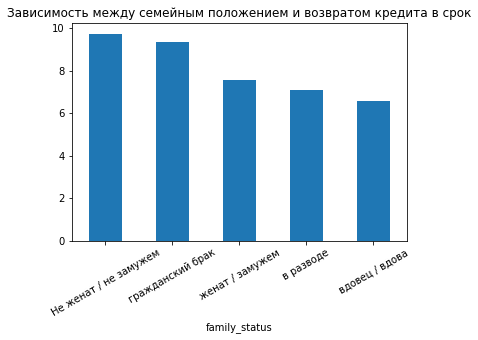

In [38]:
pivot_family_status['%'].plot.bar(rot=30).set_title('Зависимость между семейным положением и возвратом кредита в срок');

**Вывод**

Вероятность задолженности по кредиту выше у холостых/незамужних и людей в гражданском браке. Клиенты, состоящие или состоявшие в браке, являются более надежными в плане платежеспособности.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [39]:
pivot_income_group = df.pivot_table(index = ['income_group'], values = 'debt', aggfunc = ['sum', 'count', 'mean'])
pivot_income_group['mean'] = pivot_income_group['mean'] * 100
pivot_income_group.columns = ['has_debt', 'total', '%']
pivot_income_group = pivot_income_group.sort_values(by = '%', ascending = False)
pivot_income_group

,has_debt,total,%
income_group,,,
Доход 100-200,1029,11924,8.629654
Доход 50-100,331,4091,8.090931
Доход > 200,358,5066,7.066719
Доход <50,23,372,6.182796


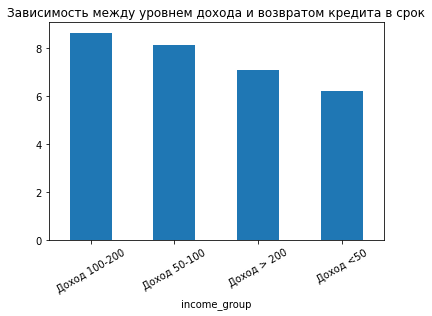

In [40]:
pivot_income_group['%'].plot.bar(rot=30).set_title('Зависимость между уровнем дохода и возвратом кредита в срок');

**Вывод**

Парадокс: клиенты с наименьшим уровнем дохода наиболее ответственны при выплате кредита. На втором месте клиенты с высоким доходом. 

- Как разные цели кредита влияют на его возврат в срок?

In [41]:
pivot_purposes = df.pivot_table(index = ['lemmas_purposes'], values = 'debt', aggfunc = ['sum', 'count', 'mean'])
pivot_purposes['mean'] = pivot_purposes['mean'] * 100
pivot_purposes.columns = ['has_debt', 'total', '%']
pivot_purposes = pivot_purposes.sort_values(by = '%', ascending = False)
pivot_purposes

,has_debt,total,%
lemmas_purposes,,,
автомобиль,403,4306,9.359034
образование,370,4013,9.220035
свадьба,186,2324,8.003442
недвижимость,782,10810,7.234043


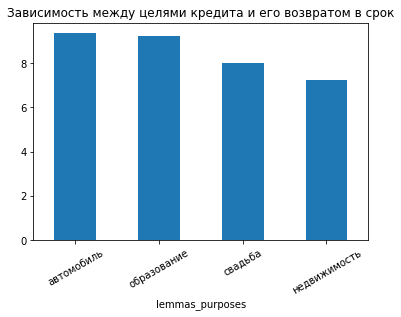

In [42]:
pivot_purposes['%'].plot.bar(rot=30).set_title('Зависимость между целями кредита и его возвратом в срок');

**Вывод**

Самая низкая вероятность задолженности у клиентов, которые берут кредит на недвижимость (покупка, строительство и т.д.). Наименее ответственно платят покупатели автомобилей. 

## Общий вывод

В результате анализа гипотеза о зависимости платежеспособности клиента от семейного положения и наличия детей получила подтверждение. На основание полученных выводов можно получить портрет идеального заемщика в общих чертах: женат (или был в браке), бездетен, низкий уровень дохода, цель кредита - операции с недвижимостью (описание условно дано в мужском роде, но действительно также и для клиента женского пола).
Возможные направления дальнейшего исследования: определить, зависит ли погашение кредита в срок от пола заемщика, подробнее рассмотреть парадокс с низким уровнем дохода.